In [1]:
import evaluate
import random

import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

# Visualization Tools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Our code
from dataloader import *
from trainer import POCMLTrainer
from model import POCML, sim
from visualizer import * 
from utils import *

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
n_obs = 9
trajectory_length = 12  # numer of node visits in a trajectory
num_desired_trajectories= 20

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.dataset.data

env.gen_dataset()
test_dataset = env.dataset.data

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Set config & hyperparameter pools for wandb

In [3]:
# Convention: for each hyperparameter key, set the value to a list if you want to try multiple values
param_pool = {  
    # data-related config; can't be automated for now
    "n_obs" : env.n_items,
    "n_states" : env.size,
    "n_actions" : env.n_actions,
    # model 
    "state_dim" : 500,
    "random_feature_dim" : [1000, 2000],
    "alpha" : 1,
    "beta_obs" : 8,
    "beta_state" : 8,
    "memory_bypass" : False,
    "mem_reweight_rate" : "adaptive", 
    "decay" : "adaptive",
    # trainer
    "lr_Q_o" : 0.1, 
    "lr_V_o" : 0.01, 
    "lr_Q_s" : 0., 
    "lr_V_s" : 0., 
    "lr_all" : 1,
    "normalize" : False,
    "reset_every" : 4,
    "refactor_memory" : True,
    # training / optimizer 
    "epochs" : 5
}

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

State kernel similarities:
 tensor([[1.0000, 0.3710, 0.3917, 0.3935, 0.3430, 0.3690, 0.3985, 0.3615, 0.3555],
        [0.3710, 1.0000, 0.3737, 0.3897, 0.3805, 0.3907, 0.3723, 0.3613, 0.3786],
        [0.3917, 0.3737, 1.0000, 0.3691, 0.3648, 0.3864, 0.3878, 0.3543, 0.3744],
        [0.3935, 0.3897, 0.3691, 1.0000, 0.3719, 0.3764, 0.3526, 0.3879, 0.3599],
        [0.3430, 0.3805, 0.3648, 0.3719, 1.0000, 0.3705, 0.3730, 0.4148, 0.3969],
        [0.3690, 0.3907, 0.3864, 0.3764, 0.3705, 1.0000, 0.3909, 0.3571, 0.3663],
        [0.3985, 0.3723, 0.3878, 0.3526, 0.3730, 0.3909, 1.0000, 0.3457, 0.3572],
        [0.3615, 0.3613, 0.3543, 0.3879, 0.4148, 0.3571, 0.3457, 1.0000, 0.4169],
        [0.3555, 0.3786, 0.3744, 0.3599, 0.3969, 0.3663, 0.3572, 0.4169, 1.0000]])
Action kernel similarities:
 tensor([[1.0000, 0.3704, 0.3466, 0.3626],
        [0.3704, 1.0000, 0.3098, 0.3965],
        [0.3466, 0.3098, 1.0000, 0.2876],
        [0.3626, 0.3965, 0.2876, 1.0000]])
Train obs accuracy/confidence: 0.21

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


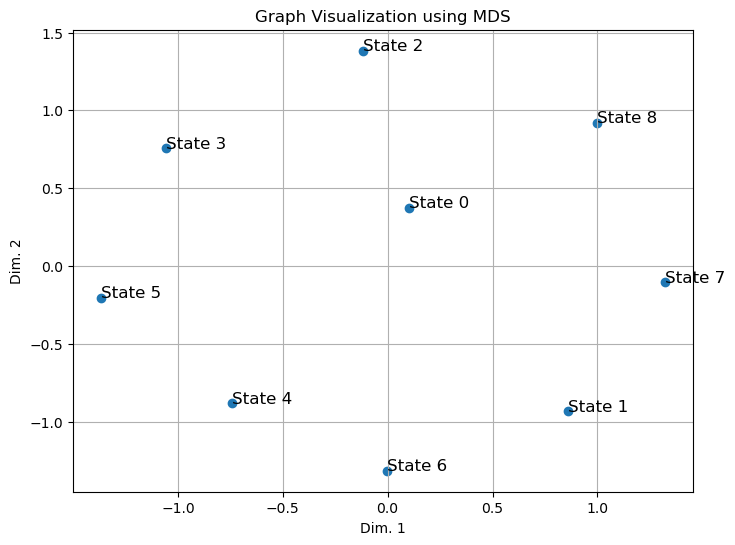

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


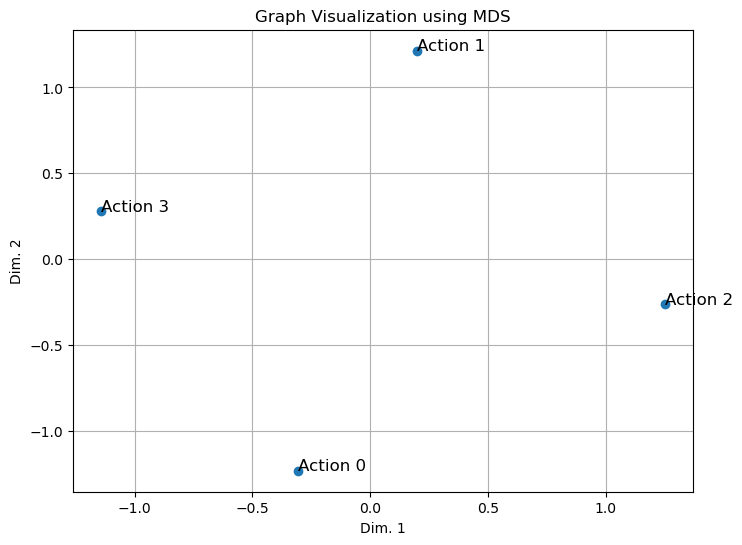

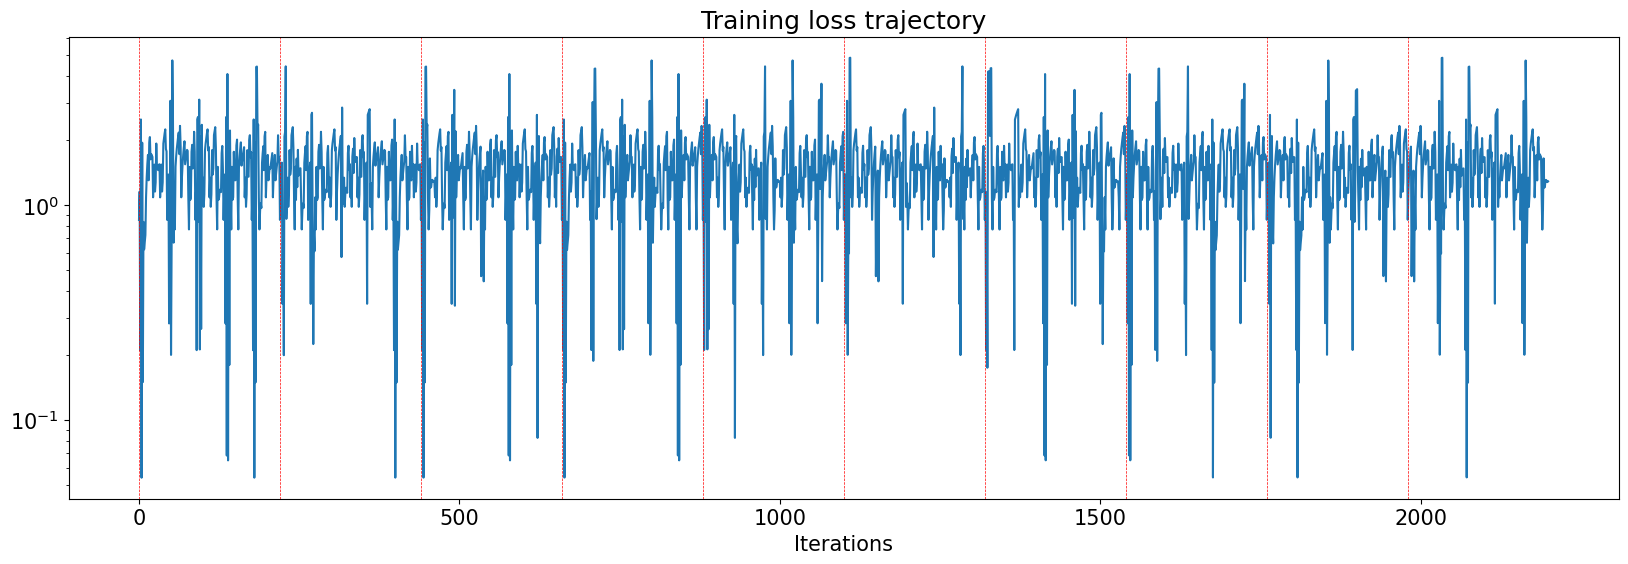

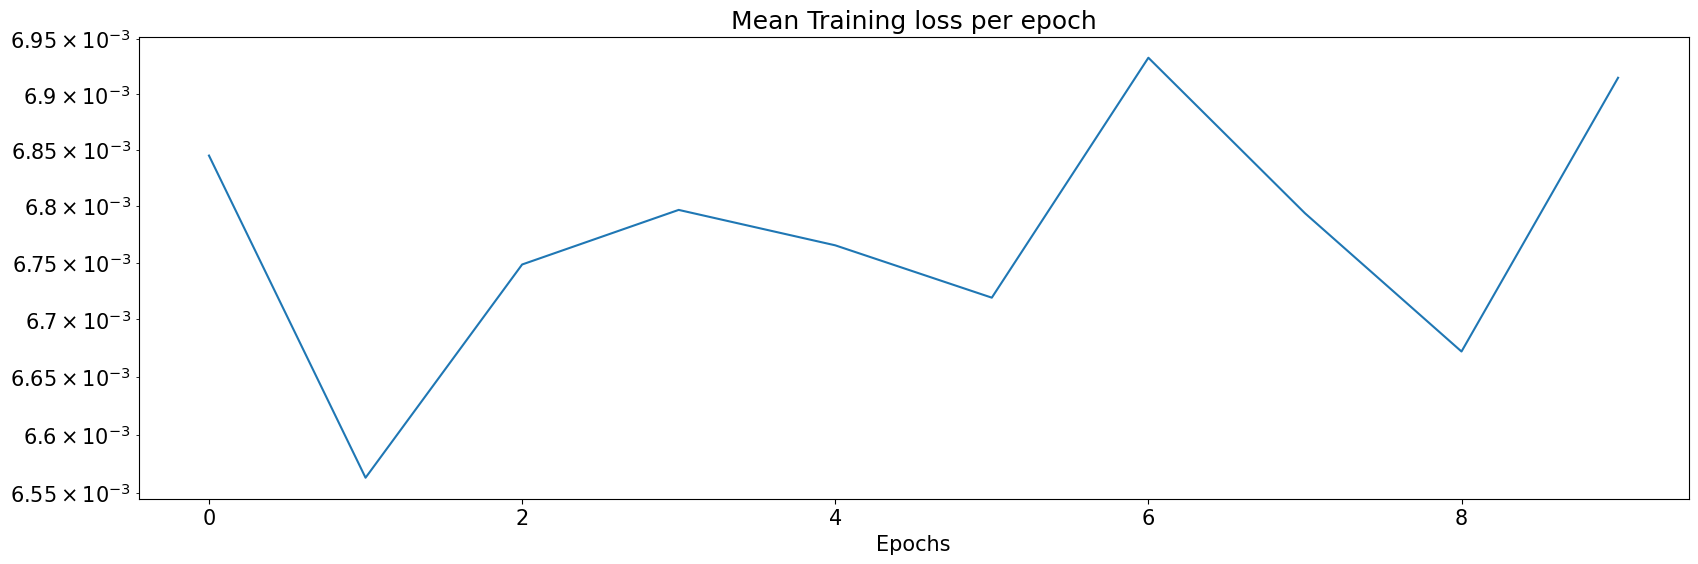

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

State kernel similarities:
 tensor([[1.0000, 0.4194, 0.3653, 0.3412, 0.3514, 0.3627, 0.4001, 0.3537, 0.3570],
        [0.4194, 1.0000, 0.3506, 0.3806, 0.3661, 0.3920, 0.3527, 0.3427, 0.3504],
        [0.3653, 0.3506, 1.0000, 0.3894, 0.3899, 0.3541, 0.3732, 0.3397, 0.4082],
        [0.3412, 0.3806, 0.3894, 1.0000, 0.3791, 0.3873, 0.3533, 0.3652, 0.3707],
        [0.3514, 0.3661, 0.3899, 0.3791, 1.0000, 0.3441, 0.3844, 0.3929, 0.3605],
        [0.3627, 0.3920, 0.3541, 0.3873, 0.3441, 1.0000, 0.3414, 0.3989, 0.3711],
        [0.4001, 0.3527, 0.3732, 0.3533, 0.3844, 0.3414, 1.0000, 0.3660, 0.3775],
        [0.3537, 0.3427, 0.3397, 0.3652, 0.3929, 0.3989, 0.3660, 1.0000, 0.3653],
        [0.3570, 0.3504, 0.4082, 0.3707, 0.3605, 0.3711, 0.3775, 0.3653, 1.0000]])
Action kernel similarities:
 tensor([[1.0000, 0.3840, 0.3809, 0.4144],
        [0.3840, 1.0000, 0.3307, 0.4134],
        [0.3809, 0.3307, 1.0000, 0.3459],
        [0.4144, 0.4134, 0.3459, 1.0000]])
Train obs accuracy/confidence: 0.15

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


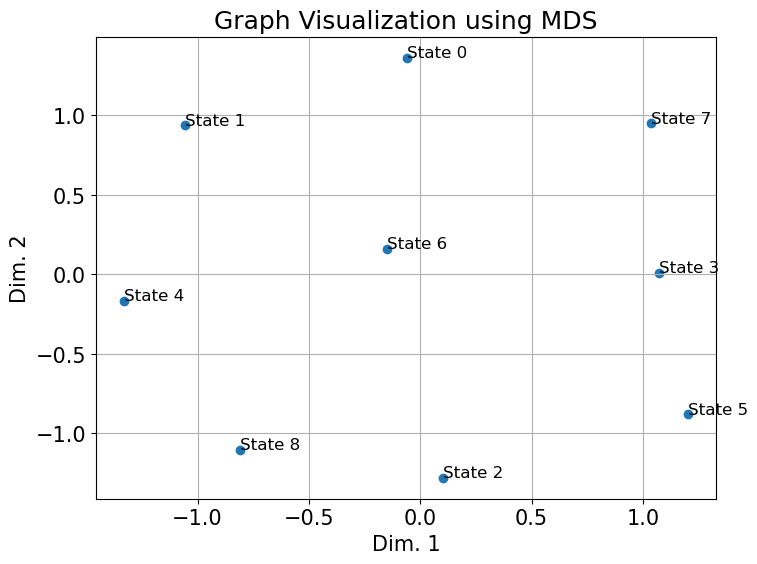

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


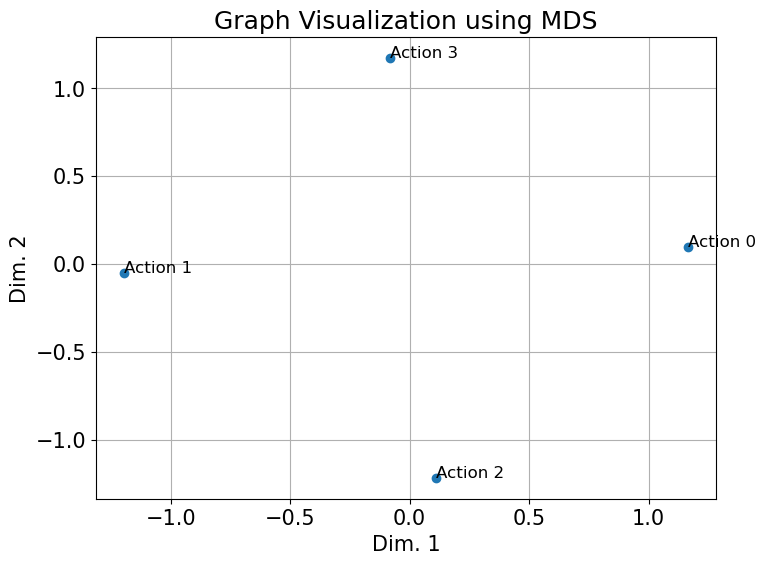

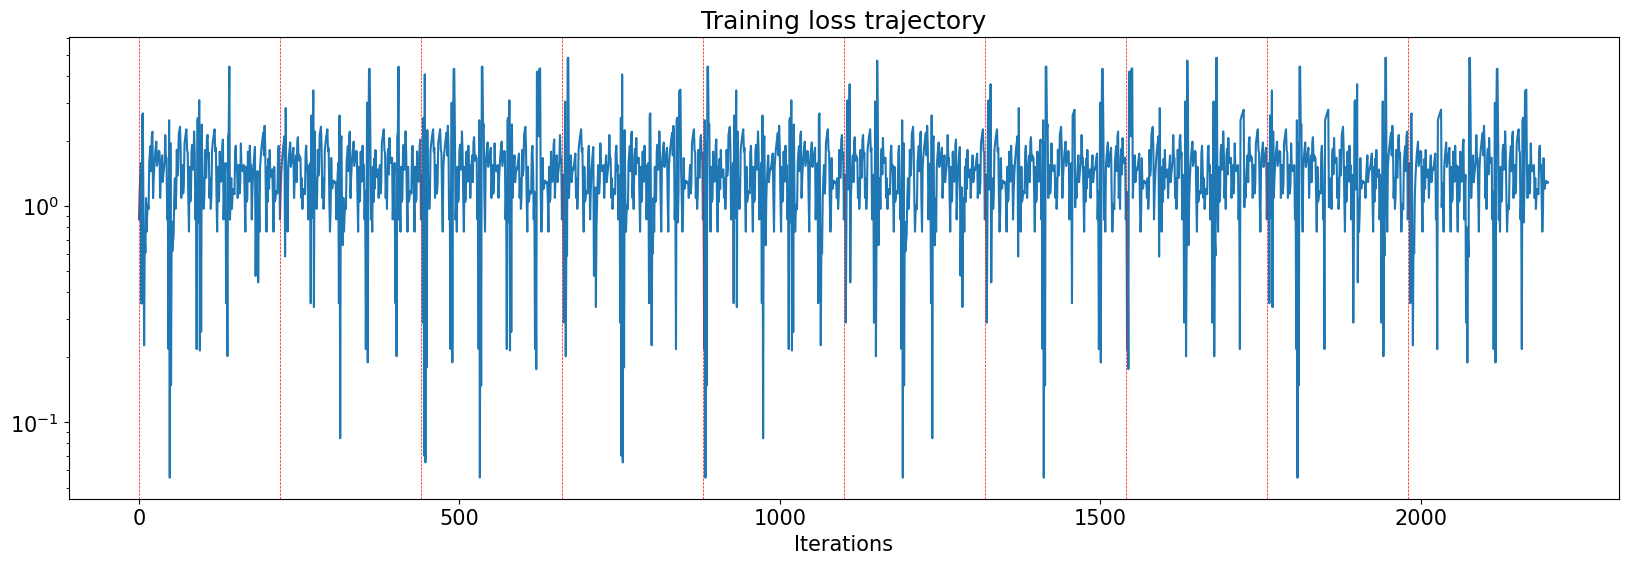

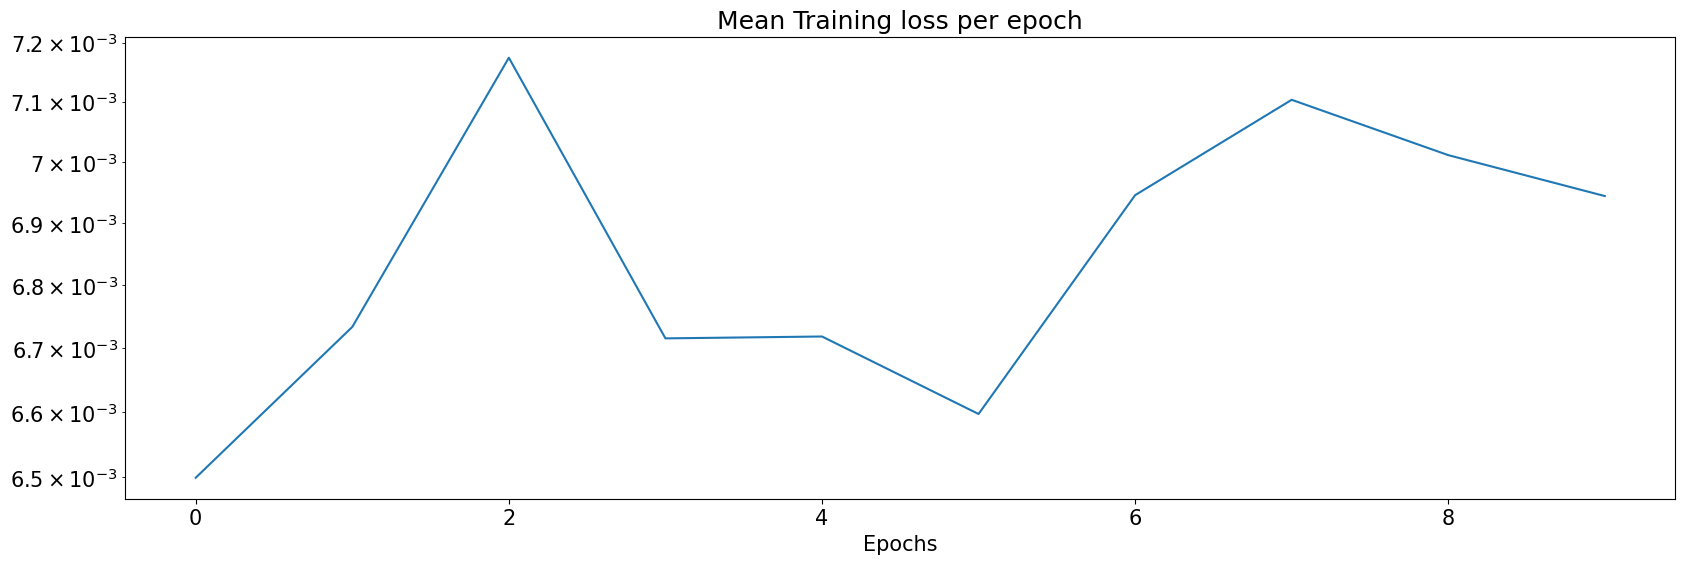

In [4]:
# Use the loader to generate combinations one at a time
param_loader = generate_combinations_loader(param_pool)

for params in param_loader:

    # Filter parameters to match the model & trainer's __init__ signature
    trainer_params = filter_param(params, POCMLTrainer)
    model_params = filter_param(params, POCML)

    # Instantiate the model & trainer using the filtered dictionary
    model = POCML(**model_params)
    trainer = POCMLTrainer(model = model, train_loader = train_dataloader, **trainer_params)
    # train the model and record its loss
    loss_record = np.array(trainer.train(params["epochs"])).reshape(params["epochs"],-1)
    
    ## Analytics
    # get state & action kernel similarities
    phi_Q = model.get_state_kernel()
    phi_V = model.get_action_kernel()
    k_sim_Q = sim(phi_Q.T, phi_Q.T)
    k_sim_V = sim(phi_V.T, phi_V.T)

    ## Evaluations
    train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
    test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
    sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)


    print("State kernel similarities:\n", k_sim_Q)
    print("Action kernel similarities:\n", k_sim_V)

    print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))
    print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))
    print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

    ## Visualization 
    visualize(model.get_state_differences().numpy(), legend = "State", title = "MDS State Differences")
    visualize(model.get_action_differences().numpy(), legend = "Action", title = "MDS Action Differences")
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=False)
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=True)

In [5]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model_12_12_1.ckpt")